# 1.&nbsp;Loading dependencies, libraries and packages

In [ ]:
!pip install shap

# Importing relevant packages and libraries
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
import shap
import random
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

from imblearn.over_sampling import RandomOverSampler, SMOTE
from scipy.stats import mode

# 2.&nbsp;Understanding the data

In [ ]:
# Reading dataset
df = pd.read_csv("/content/drive/MyDrive/DSA4266/train.csv")

In [ ]:
df

,order_id,service_type,driver_status,date,hour,seconds,latitude,longitude,altitude_in_meters,accuracy_in_meters,label
0,RB193,GO_RIDE,UNAVAILABLE,2018-02-05,6,1548890667,-6.922910,107.631301,NaN,23.027,0
1,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890680,-6.923039,107.631250,712.000000,9.577,0
2,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890690,-6.923039,107.631250,712.000000,9.577,0
3,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890700,-6.923048,107.631230,713.000000,8.139,0
4,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890710,-6.922968,107.631253,713.000000,7.029,0
...,...,...,...,...,...,...,...,...,...,...,...
567540,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803198,-6.889018,107.595516,798.799988,21.381,1
567541,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803208,-6.889020,107.595516,798.799988,19.621,1
567542,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803218,-6.889017,107.595526,798.799988,18.012,1
567543,RB261,GO_RIDE,OTW_DROPOFF,2018-03-22,13,1552803228,-6.889017,107.595526,798.799988,18.012,1


In [ ]:
# Each order_id (unique ride) includes several observations (“pings”)
df["order_id"].value_counts()

RB622    685
RB82     667
F985     660
F1685    656
F1160    600
        ... 
RB952      3
F803       2
RB637      2
F601       1
F1462      1
Name: order_id, Length: 3500, dtype: int64

In [ ]:
# Checking NA count in each column
nan_count = df.isna().sum()
nan_count

order_id                   0
service_type               0
driver_status              0
date                       0
hour                       0
seconds                    0
latitude                   0
longitude                  0
altitude_in_meters    154403
accuracy_in_meters         0
label                      0
dtype: int64

# 3.&nbsp;Data Preparation

## 3.1&nbsp;Handling missing data

In [ ]:
# Dropping of altitude in metres column as there are many NaNs
df = df.drop(columns=['altitude_in_meters'])

Given that we are primarily interested in calculating distances between consecutive "pings" using longitude and latitude data, the altitude_in_meters variable is deemed less relevant for this purpose, especially considering that we are not dealing with long distances. Consequently, due to the abundance of missing values (NA's) for this variable, we opt to remove altitude_in_meters from our dataset. This streamlines our analysis by focusing solely on the essential spatial coordinates, latitude, and longitude, ensuring our distance calculations are based on the most pertinent information.

## 3.2&nbsp;Convert categorical variables to numerical (One-hot encoding)

In [ ]:
# Converting categorical variables to numerical through one-hot encoding to prevent any order or weightage through label encoding
encoded_columns = pd.get_dummies(df[['service_type', 'driver_status']], prefix=['service_type', 'driver_status'])

# Concatenate the original DataFrame with the encoded columns
df = pd.concat([df, encoded_columns], axis=1)

In [ ]:
df.head()

,order_id,service_type,driver_status,date,hour,seconds,latitude,longitude,accuracy_in_meters,label,service_type_GO_FOOD,service_type_GO_RIDE,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE
0,RB193,GO_RIDE,UNAVAILABLE,2018-02-05,6,1548890667,-6.922910,107.631301,23.027,0,0,1,0,0,0,1
1,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890680,-6.923039,107.631250,9.577,0,0,1,1,0,0,0
2,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890690,-6.923039,107.631250,9.577,0,0,1,1,0,0,0
3,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890700,-6.923048,107.631230,8.139,0,0,1,1,0,0,0
4,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890710,-6.922968,107.631253,7.029,0,0,1,1,0,0,0


## 3.3&nbsp;Convert linux seconds to datetime format

In [ ]:
from datetime import datetime

df.dropna(subset=['seconds'], inplace=True)

# Convert Linux seconds to datetime format
df['linux_date'] = [datetime.utcfromtimestamp(s).strftime('%Y-%m-%d %H:%M:%S') for s in df.seconds.values]

# Convert datetime to Pandas format
df['linux_date'] = pd.to_datetime(df['linux_date'])

# Convert datetime in date column to Pandas format
df['date'] = pd.to_datetime(df['date'])

# Check if date column match with Linux date column
df_check = df['linux_date'].dt.date==df['date']
print(df_check.eq(True).all())




False


Unforutunately, the seconds column which is in Unix form does not match the date, hour columns given. No possible reason. Feel there is a data mismatch in the data provided.

In [ ]:
df.head()

,order_id,service_type,driver_status,date,hour,seconds,latitude,longitude,accuracy_in_meters,label,service_type_GO_FOOD,service_type_GO_RIDE,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE,linux_date
0,RB193,GO_RIDE,UNAVAILABLE,2018-02-05,6,1548890667,-6.922910,107.631301,23.027,0,0,1,0,0,0,1,2019-01-30 23:24:27
1,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890680,-6.923039,107.631250,9.577,0,0,1,1,0,0,0,2019-01-30 23:24:40
2,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890690,-6.923039,107.631250,9.577,0,0,1,1,0,0,0,2019-01-30 23:24:50
3,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890700,-6.923048,107.631230,8.139,0,0,1,1,0,0,0,2019-01-30 23:25:00
4,RB193,GO_RIDE,AVAILABLE,2018-02-05,6,1548890710,-6.922968,107.631253,7.029,0,0,1,1,0,0,0,2019-01-30 23:25:10


# 4.&nbsp;Data Visualisation

In [ ]:
unique_order_ids = df['order_id'].unique()
unique_order_ids, len(unique_order_ids)

(array(['RB193', 'F1452', 'F943', ..., 'RB88', 'RB1812', 'RB261'],
       dtype=object),
 3500)

In [ ]:
df.columns

Index(['order_id', 'service_type', 'driver_status', 'date', 'hour', 'seconds',
       'latitude', 'longitude', 'accuracy_in_meters', 'label',
       'service_type_GO_FOOD', 'service_type_GO_RIDE',
       'driver_status_AVAILABLE', 'driver_status_OTW_DROPOFF',
       'driver_status_OTW_PICKUP', 'driver_status_UNAVAILABLE', 'linux_date'],
      dtype='object')

In [ ]:
print(df.describe())

                hour       seconds       latitude      longitude  \
count  567545.000000  5.675450e+05  567545.000000  567545.000000   
mean       14.435453  1.550739e+09      -6.902215     107.594670   
std         4.942749  1.123543e+06       0.141004       0.110761   
min         0.000000  1.548891e+09     -66.655409      63.592748   
25%        11.000000  1.549779e+09      -6.922561     107.551299   
50%        15.000000  1.550658e+09      -6.893074     107.603726   
75%        18.000000  1.551677e+09      -6.878771     107.627953   
max        23.000000  1.552855e+09      -6.804238     107.776651   

       accuracy_in_meters          label  service_type_GO_FOOD  \
count       567545.000000  567545.000000         567545.000000   
mean            31.031366       0.719034              0.591782   
std            199.671686       0.449471              0.491504   
min              0.010000       0.000000              0.000000   
25%              0.500000       0.000000              0.0

## 4.1&nbsp;Correlation heatmap to find out columns that are similar

<ipython-input-69-55672fce226a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")


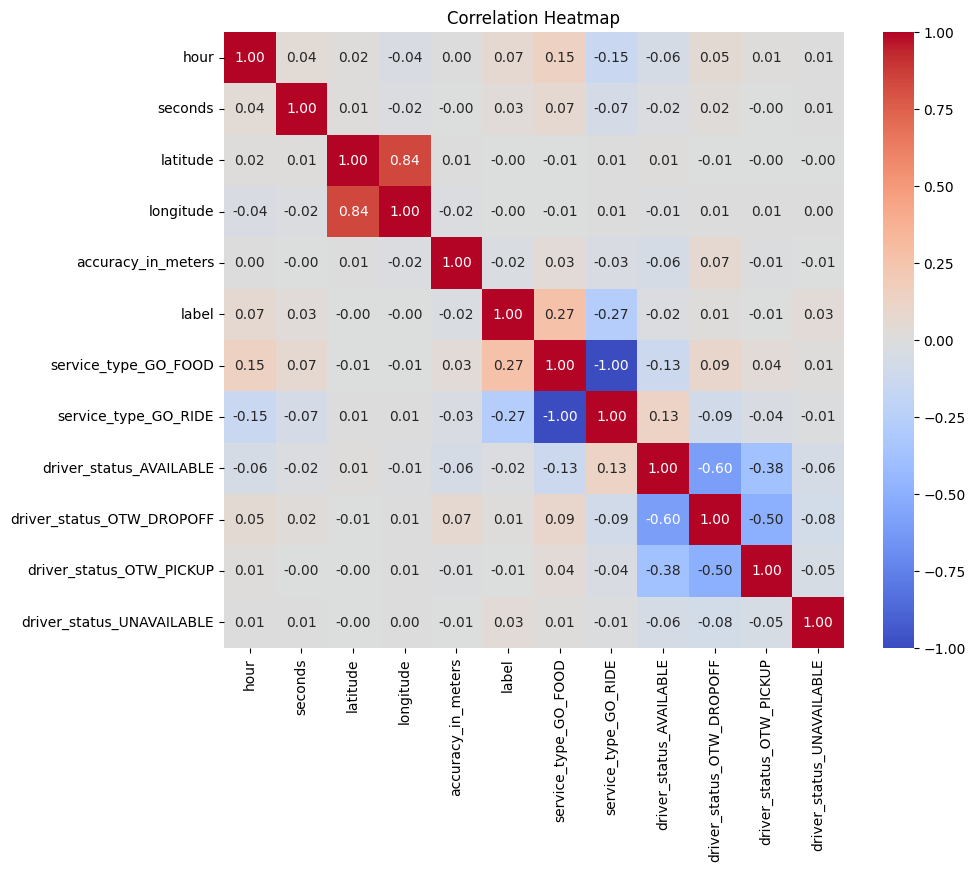

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## 4.2&nbsp;Driver Status vs Accuracy of Ping across different services

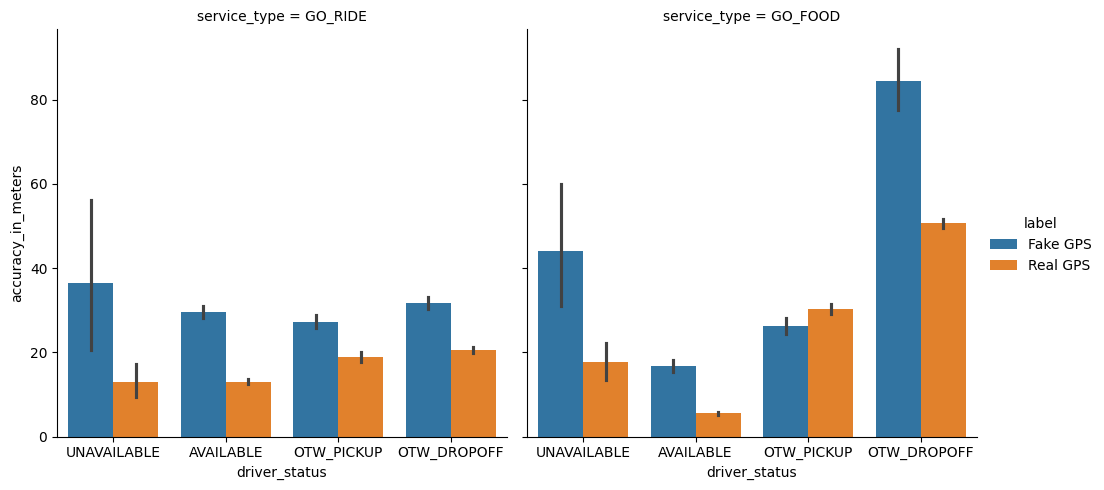

In [ ]:
# Create a copy of the original DataFrame
df2 = df.copy()

# Define the mapping for label replacement
label_mapping = {0: 'Fake GPS', 1: 'Real GPS'}

# Replace the labels in the 'label' column
df2['label'] = df2['label'].replace(label_mapping)

sns.catplot(data=df2, x='driver_status', y='accuracy_in_meters', hue='label', col='service_type', kind='bar')


The lower number in the plot here means higher accuracy. If it could go down to 10m, you can detect a location as close as 10m which translates to higher accuracy.

## 4.3&nbsp;Count of Service Types for Unique Order IDs

<ipython-input-71-a44e63b8a940>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='service_type', data=filtered_df, palette=color_map)


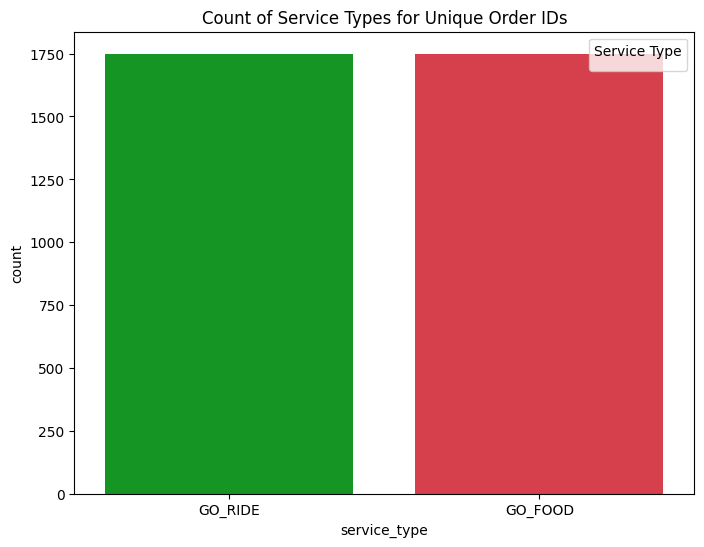

In [ ]:
# Filter the DataFrame based on unique order IDs
filtered_df = df[df['order_id'].isin(unique_order_ids)]
filtered_df = filtered_df.drop_duplicates(subset='order_id', keep='first')

# Create a count plot for 'service_type'
color_map = {'GO_RIDE': '#00AA13', 'GO_FOOD': '#ee2737'}
plt.figure(figsize=(8, 6))
sns.countplot(x='service_type', data=filtered_df, palette=color_map)
plt.title('Count of Service Types for Unique Order IDs')
plt.legend(title='Service Type')
plt.show()

We observe a balanced distribution of order IDs between GO_RIDE and GO_FOOD services.

## 4.4&nbsp;Distribution of Fake vs Real IDs across different service types

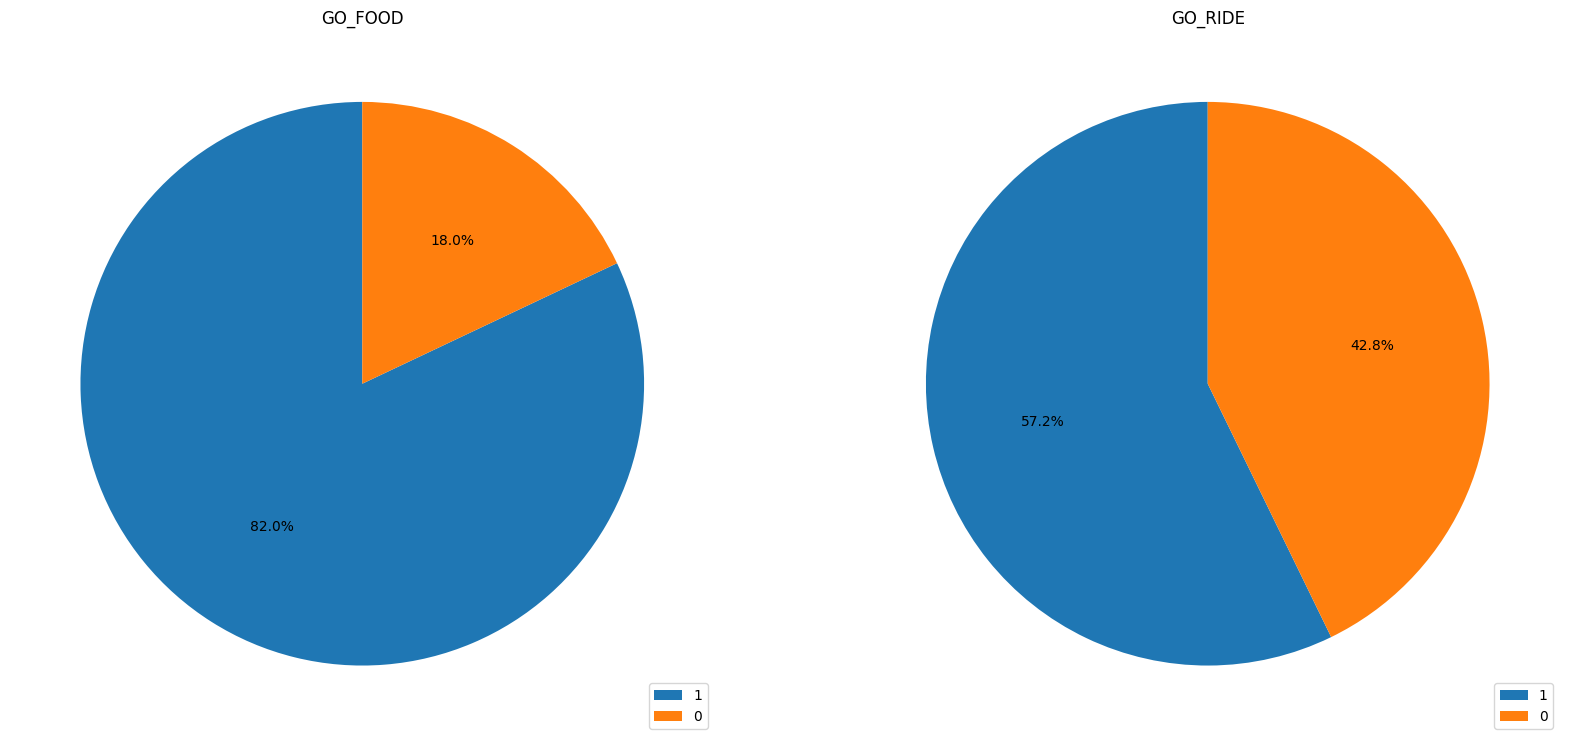

In [ ]:
# Function to plot distribution
def plot_service_type_pie(variable):

    # Plot on a pie chart
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))


    data_0 = df[df.service_type=="GO_FOOD"][variable].value_counts()
    labels = data_0.index
    ax1.pie(data_0, autopct='%1.1f%%',startangle=90)
    ax1.set_title('GO_FOOD')
    ax1.legend(labels, loc="lower right")

    data_1 = df[df.service_type=="GO_RIDE"][variable].value_counts()
    labels = data_1.index
    ax2.pie(data_1, autopct='%1.1f%%', startangle=90)
    ax2.set_title('GO_RIDE')

    ax2.legend(labels, loc="lower right")

    plt.show()

# Plot on a pie chart
plot_service_type_pie("label")

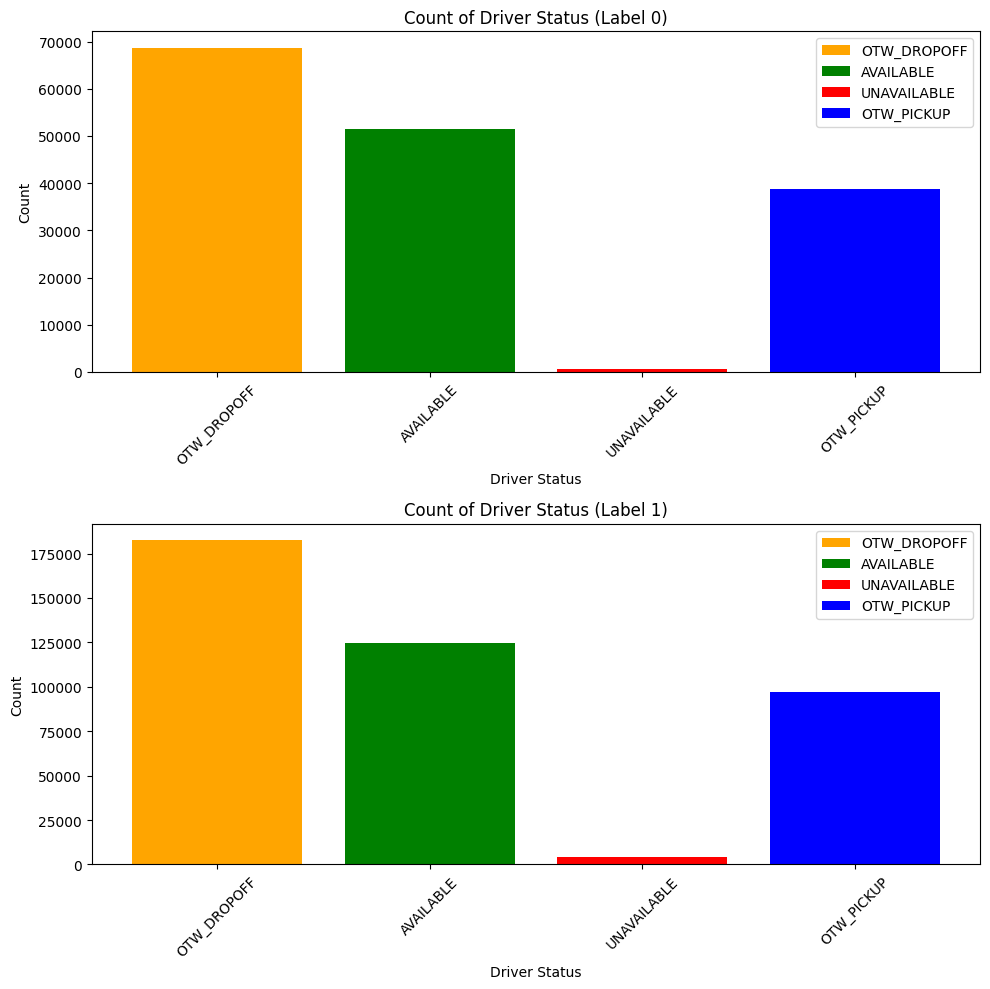

In [ ]:
filtered_df_label_0 = df[df['label'] == 0]

# Filter DataFrame where label == 1
filtered_df_label_1 = df[df['label'] == 1]

# Define colors for each driver status
color_mapping = {
    'OTW_DROPOFF': 'orange',
    'AVAILABLE': 'green',
    'UNAVAILABLE': 'red',
    'OTW_PICKUP': 'blue'
}

# Plot count based on driver_status for label 0
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
for i, (status, color) in enumerate(color_mapping.items()):
    counts = filtered_df_label_0[filtered_df_label_0['driver_status'] == status]['driver_status'].value_counts()
    labels = [f'{status}: {count}' for count in counts]
    plt.bar([i], counts, color=color, label=status)
plt.title('Count of Driver Status (Label 0)')
plt.xlabel('Driver Status')
plt.ylabel('Count')
plt.xticks(range(len(color_mapping)), color_mapping.keys(), rotation=45)
plt.legend()

# Plot count based on driver_status for label 1
plt.subplot(2, 1, 2)
for i, (status, color) in enumerate(color_mapping.items()):
    counts = filtered_df_label_1[filtered_df_label_1['driver_status'] == status]['driver_status'].value_counts()
    labels = [f'{status}: {count}' for count in counts]
    plt.bar([i], counts, color=color, label=status)
plt.title('Count of Driver Status (Label 1)')
plt.xlabel('Driver Status')
plt.ylabel('Count')
plt.xticks(range(len(color_mapping)), color_mapping.keys(), rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

The distribution of pings across different driver_status is quite similar for both fake and real order ids.

## 4.5&nbsp;Distribution of driver status across different service types

<Axes: xlabel='service_type'>

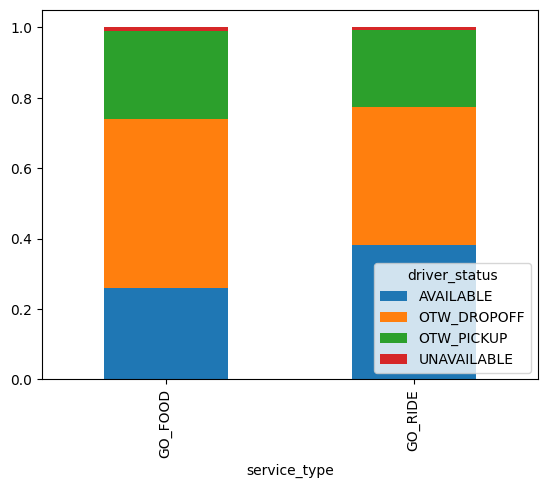

In [ ]:
df.groupby('service_type')['driver_status'].value_counts(normalize=True).unstack('driver_status').plot.bar(stacked=True)

The "GO_RIDE" service spends more time "AVAILABLE" than the "GO_FOOD" service.

## 4.5 &nbsp; Visualise an order_id on map

In [ ]:
def plot_folium(df, label, lat_column, lon_column, zoom_start=10, order_id=None):
    # Filter DataFrame by label
    df = df[df['label'] == label]

    # If order_id is not provided, select a random order_id from the filtered DataFrame
    if order_id is None:
        order_ids = df['order_id'].unique()
        if len(order_ids) == 0:
            print("No orders found for the given label.")
            return
        order_id = random.choice(order_ids)

    # Select subset of dataframe by order ID
    df = df[df['order_id'] == order_id]

    # Calculate the center of the map
    center_lat = df[lat_column].mean()
    center_lon = df[lon_column].mean()

    # Folium plot
    my_map = folium.Map(location=[center_lat, center_lon], zoom_start=zoom_start)

    # Define different colors for status and corresponding labels
    color_mapping = {
        'UNAVAILABLE': 'red',
        'AVAILABLE': 'green',
        'OTW_PICKUP': 'black',
        'OTW_DROPOFF': 'blue'
    }

    # Add markers to the map
    for index, row in df.iterrows():
        color = color_mapping.get(row['driver_status'], 'gray')
        popup_text = f"Latitude: {row[lat_column]}<br>Longitude: {row[lon_column]}<br>Status: {row['driver_status']}"
        popup = folium.Popup(popup_text, parse_html=True)
        folium.CircleMarker(
            location=[row[lat_column], row[lon_column]],
            radius=3,
            color=color,
            fill=True,
            fill_color=color,
            popup=popup
        ).add_to(my_map)

    # Add legend to the map
    legend_html = '''
    <div style="position: fixed;
                 bottom: 30px; left: 50px; width: 150px; height: 120px;
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color: white;
    ">&nbsp; <b>Legend</b> <br>'''
    for status, color in color_mapping.items():
        legend_html += f'&nbsp; <i class="fa fa-circle" style="color:{color}"></i> {status}<br>'
    legend_html += '</div>'
    my_map.get_root().html.add_child(folium.Element(legend_html))

    return my_map

### 4.5.1&nbsp;Plot an order_id with FAKE GPS

In [ ]:
fake_map = plot_folium(df, label=0, lat_column='latitude', lon_column='longitude',zoom_start=13)
display(fake_map)

### 4.5.2&nbsp;Plot an order_id with REAL GPS

In [ ]:
real_map = plot_folium(df, label=1, lat_column='latitude', lon_column='longitude',zoom_start=13)
display(real_map)

# 5.&nbsp;Feature Engineering

## 5.1&nbsp;Count pings with UNAVAILABLE driver_status for each order_id

In [ ]:
# Group by 'order_id' and sort by 'seconds' within each group
df_sorted = df.groupby('order_id').apply(lambda x: x.sort_values('seconds')).reset_index(drop=True)

df_sorted['unavailable_count'] = df_sorted.groupby('order_id')['driver_status'].transform(lambda x: (x == 'UNAVAILABLE').sum())

## 5.2&nbsp;Calculate time difference between consecutive pings for each order_id

In [ ]:
# Calculate time difference between consecutive rows of 'seconds' within each group
df_sorted['time_diff_seconds'] = df_sorted.groupby('order_id')['seconds'].diff()

In [ ]:
df_sorted

,order_id,service_type,driver_status,date,hour,seconds,latitude,longitude,accuracy_in_meters,label,service_type_GO_FOOD,service_type_GO_RIDE,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE,linux_date,unavailable_count,time_diff_seconds
0,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065855,-6.874573,107.604420,0.100,1,1,0,1,0,0,0,2019-02-25 03:37:35,2,NaN
1,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065865,-6.874573,107.604420,0.100,1,1,0,1,0,0,0,2019-02-25 03:37:45,2,10.0
2,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065875,-6.874573,107.604420,0.100,1,1,0,1,0,0,0,2019-02-25 03:37:55,2,10.0
3,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065885,-6.874573,107.604420,0.100,1,1,0,1,0,0,0,2019-02-25 03:38:05,2,10.0
4,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065895,-6.874573,107.604420,0.100,1,1,0,1,0,0,0,2019-02-25 03:38:15,2,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567540,RB999,GO_RIDE,AVAILABLE,2018-02-21,8,1550280725,-6.917615,107.598171,3.279,0,0,1,1,0,0,0,2019-02-16 01:32:05,1,10.0
567541,RB999,GO_RIDE,AVAILABLE,2018-02-21,8,1550280734,-6.917615,107.598171,3.279,0,0,1,1,0,0,0,2019-02-16 01:32:14,1,9.0
567542,RB999,GO_RIDE,UNAVAILABLE,2018-02-21,8,1550280736,-6.917611,107.598180,3.000,0,0,1,0,0,0,1,2019-02-16 01:32:16,1,2.0
567543,RB999,GO_RIDE,AVAILABLE,2018-02-21,8,1550280748,-6.917614,107.598182,3.000,0,0,1,1,0,0,0,2019-02-16 01:32:28,1,12.0


## 5.3&nbsp;Calculate distances between consecutive pings of each order_id

In [ ]:
# Haversine formula to calculate distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # radius of the Earth in km

    # Convert latitude and longitude from degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Calculate the change in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Calculate distance using Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

# Calculate distance between consecutive rows
def calculate_distance(group):
    prev_lat = group['latitude'].shift()
    prev_lon = group['longitude'].shift()
    distances = []
    for idx, row in group.iterrows():
        if not pd.isna(prev_lat[idx]) and not pd.isna(prev_lon[idx]):
            distance = haversine(row['latitude'], row['longitude'], prev_lat[idx], prev_lon[idx])
            distances.append(distance)
        else:
            distances.append(None)
    return distances


In [ ]:
# Group by order_id and calculate distance
df_sorted['distance'] = df_sorted.groupby('order_id').apply(calculate_distance).explode().reset_index(drop=True)

## 5.4&nbsp;Calculate speed using distance and time_diff_seconds for consecutive pings of each order_id

In [ ]:
# Fill NaN values in time_diff_seconds with 0
df_sorted['time_diff_seconds'].fillna(0, inplace=True)

# Replace None values in distance column with 0
df_sorted['distance'].fillna(0, inplace=True)

# Calculate speed (velocity) by dividing distance by time difference
df_sorted['speed'] = 0  # Initialize speed column with zeros
non_zero_mask = (df_sorted['time_diff_seconds'] != 0) & (df_sorted['distance'] != 0)
df_sorted.loc[non_zero_mask, 'speed'] = df_sorted['distance'] / (df_sorted['time_diff_seconds'] / 3600)

## 5.5&nbsp; Calculate latitude and longitude difference for consecutive pings of each order_id

In [ ]:
# Group by 'order_id' and calculate differences in latitude and longitude
df_grouped = df_sorted.groupby('order_id')
df_sorted['lat_diff'] = df_grouped['latitude'].diff()
df_sorted['lon_diff'] = df_grouped['longitude'].diff()

## 5.6&nbsp; Calculate change in latitude and longitude per second for consecutive pings of each order_id

In [ ]:
# Calculate rates of change in latitude and longitude (degrees per second)
df_sorted['lat_rate'] = df_sorted['lat_diff'] / df_sorted['time_diff_seconds']
df_sorted['lon_rate'] = df_sorted['lon_diff'] / df_sorted['time_diff_seconds']

## 5.7&nbsp;Calculate geospatial aggregates using latitude and longitude columns to derive mean, median, min, max, count

In [ ]:
# Group by 'order_id' and compute geospatial aggregates
geospatial_aggregates = df_sorted.groupby('order_id').agg({
    'latitude': ['mean', 'median', 'min', 'max', 'count'],  # Example aggregates for latitude
    'longitude': ['mean', 'median', 'min', 'max', 'count'],  # Example aggregates for longitude
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
geospatial_aggregates.columns = ['_'.join(col) for col in geospatial_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(geospatial_aggregates, how='left', on='order_id')

## 5.8&nbsp;Calculate speed aggregates using speed column to derive mean, median, min, max

In [ ]:
# Group by 'order_id' and compute speed aggregates for speed
speed_aggregates = df_sorted.groupby('order_id').agg({
    'speed': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
speed_aggregates.columns = ['_'.join(col) for col in speed_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(speed_aggregates, how='left', on='order_id')

## 5.9&nbsp;Calculate distance aggregates using distance column to derive mean, median, min, max, count

In [ ]:
# Group by 'order_id' and compute distance aggregates for speed
distance_aggregates = df_sorted.groupby('order_id').agg({
    'distance': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
distance_aggregates.columns = ['_'.join(col) for col in distance_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(distance_aggregates, how='left', on='order_id')

## 5.10&nbsp;Calculate accuracy aggregates using accuracy_in_meters column to derive mean, median, min, max

In [ ]:
# Group by 'order_id' and compute geospatial aggregates for speed
acc_aggregates = df_sorted.groupby('order_id').agg({
    'accuracy_in_meters': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
acc_aggregates.columns = ['_'.join(col) for col in acc_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(acc_aggregates, how='left', on='order_id')

## 5.10&nbsp;Calculate time difference aggregates using time_diff_seconds column to derive mean, median, min, max

In [ ]:
# Group by 'order_id' and compute time_diff aggregates for speed
time_diff_aggregates = df_sorted.groupby('order_id').agg({
    'time_diff_seconds': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
time_diff_aggregates.columns = ['_'.join(col) for col in time_diff_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(time_diff_aggregates, how='left', on='order_id')

##5.11&nbsp;Calculate latitude rate aggregates using lat_rate column to derive mean, median, min, max

In [ ]:
# Group by 'order_id' and compute time_diff aggregates for speed
lat_rate_aggregates = df_sorted.groupby('order_id').agg({
    'lat_rate': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
lat_rate_aggregates.columns = ['_'.join(col) for col in lat_rate_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(lat_rate_aggregates, how='left', on='order_id')

## 5.12&nbsp;Calculate lon_rate aggregates using longitude_rate column to derive mean, median, min, max

In [ ]:
# Group by 'order_id' and compute time_diff aggregates for speed
lon_rate_aggregates = df_sorted.groupby('order_id').agg({
    'lon_rate': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
lon_rate_aggregates.columns = ['_'.join(col) for col in lon_rate_aggregates.columns]

# Merge aggregates with original DataFrame
df_sorted = df_sorted.merge(lon_rate_aggregates, how='left', on='order_id')

## 5.13&nbsp;Calculate otw_pickup_time using the time difference between the first and the last ping when driver status is OTW_PICKUP

In [ ]:
# Group by 'order_id'
grouped_df = df_sorted.groupby('order_id')

# Initialize an empty dictionary to store the results
otw_pickup_times = {}

# Iterate over each group
for order_id, group_df in grouped_df:
    # Filter rows with driver_status equal to 'OTW_PICKUP'
    otw_pickup_df = group_df[group_df['driver_status'] == 'OTW_PICKUP']

    # Check if there are at least two rows with 'OTW_PICKUP' status
    if len(otw_pickup_df) >= 2:
        # Calculate the time difference between the last and first value in the 'seconds' column
        time_difference = otw_pickup_df['seconds'].iloc[-1] - otw_pickup_df['seconds'].iloc[0]

        # Store the time difference in the dictionary
        otw_pickup_times[order_id] = time_difference
    else:
        # If there are fewer than two rows with 'OTW_PICKUP' status, store NaN
        otw_pickup_times[order_id] = np.nan

# Convert the dictionary to a DataFrame
otw_pickup_times_df = pd.DataFrame.from_dict(otw_pickup_times, orient='index', columns=['otw_pickup_time'])

# Reset the index to have 'order_id' as a column
otw_pickup_times_df.reset_index(inplace=True)
otw_pickup_times_df.rename(columns={'index': 'order_id'}, inplace=True)

# Merge otw_pickup_times_df with the original DataFrame
merged_df = df_sorted.merge(otw_pickup_times_df, on='order_id', how='left')

## 5.14&nbsp;Calculate otw_pickup_time aggregates using otw_pickup_time column to derive mean, median, min, max

In [ ]:
# Group by 'order_id' and compute otw_pickup aggregates for speed
otwpickup_aggregates = merged_df.groupby('order_id').agg({
    'otw_pickup_time': ['mean', 'median', 'min', 'max'],  # Example aggregates for speed
    # Add more columns and corresponding aggregate functions as needed
})

# Flatten multi-level column index
otwpickup_aggregates.columns = ['_'.join(col) for col in otwpickup_aggregates.columns]

# Merge aggregates with original DataFrame
merged_df = merged_df.merge(otwpickup_aggregates, how='left', on='order_id')

In [ ]:
merged_df.head()

,order_id,service_type,driver_status,date,hour,seconds,latitude,longitude,accuracy_in_meters,label,...,lat_rate_max,lon_rate_mean,lon_rate_median,lon_rate_min,lon_rate_max,otw_pickup_time,otw_pickup_time_mean,otw_pickup_time_median,otw_pickup_time_min,otw_pickup_time_max
0,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065855,-6.874573,107.60442,0.1,1,...,0.000089,1.780660e-07,0.0,-0.00006,0.000025,341.0,341.0,341.0,341.0,341.0
1,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065865,-6.874573,107.60442,0.1,1,...,0.000089,1.780660e-07,0.0,-0.00006,0.000025,341.0,341.0,341.0,341.0,341.0
2,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065875,-6.874573,107.60442,0.1,1,...,0.000089,1.780660e-07,0.0,-0.00006,0.000025,341.0,341.0,341.0,341.0,341.0
3,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065885,-6.874573,107.60442,0.1,1,...,0.000089,1.780660e-07,0.0,-0.00006,0.000025,341.0,341.0,341.0,341.0,341.0
4,F0,GO_FOOD,AVAILABLE,2018-03-02,10,1551065895,-6.874573,107.60442,0.1,1,...,0.000089,1.780660e-07,0.0,-0.00006,0.000025,341.0,341.0,341.0,341.0,341.0


## 5.15 Subsetting columns for train df and keeping only one row for each order_id

In [ ]:
train = merged_df[
    [
        "order_id",
        "service_type_GO_FOOD",
        "service_type_GO_RIDE",
        "driver_status_AVAILABLE",
        "driver_status_OTW_DROPOFF",
        "driver_status_OTW_PICKUP",
        "driver_status_UNAVAILABLE",
        "label",
        "unavailable_count",
        "latitude_mean",
        "latitude_median",
        "latitude_min",
        "latitude_max",
        "longitude_mean",
        "longitude_median",
        "longitude_min",
        "longitude_max",
        'speed_mean',
        'speed_median',
        'speed_min',
        'speed_max',
        'distance_mean',
        'distance_median',
        'distance_min',
       'distance_max',
        'accuracy_in_meters_mean',
       'accuracy_in_meters_median',
        'accuracy_in_meters_min',
       'accuracy_in_meters_max',
       'otw_pickup_time_mean',
        'otw_pickup_time_median',
        'otw_pickup_time_min',
       'otw_pickup_time_max',
        'lat_rate_mean',
        'lat_rate_median',
        'lat_rate_min',
        'lat_rate_max',
        'lon_rate_mean',
        'lon_rate_median',
        'lon_rate_min',
        'lon_rate_max',
    ]
]

In [ ]:
aggregated_data_first = train.groupby('order_id').first().reset_index()
aggregated_data_first

,order_id,service_type_GO_FOOD,service_type_GO_RIDE,driver_status_AVAILABLE,driver_status_OTW_DROPOFF,driver_status_OTW_PICKUP,driver_status_UNAVAILABLE,label,unavailable_count,latitude_mean,...,otw_pickup_time_min,otw_pickup_time_max,lat_rate_mean,lat_rate_median,lat_rate_min,lat_rate_max,lon_rate_mean,lon_rate_median,lon_rate_min,lon_rate_max
0,F0,1,0,1,0,0,0,1,2,-6.876199,...,341.0,341.0,-0.000001,0.0,-0.001069,0.000089,1.780660e-07,0.000000e+00,-0.000060,0.000025
1,F1,1,0,1,0,0,0,1,2,-6.878332,...,1484.0,1484.0,-0.000002,0.0,-0.000085,0.000496,-4.716890e-07,0.000000e+00,-0.000060,0.000095
2,F100,1,0,0,0,0,1,1,2,-6.884306,...,2100.0,2100.0,0.000004,0.0,-0.000022,0.000447,2.183158e-06,0.000000e+00,-0.000014,0.000066
3,F1000,1,0,0,1,0,0,0,0,-6.929476,...,701.0,701.0,0.000008,0.0,-0.000067,0.000094,-1.482305e-05,0.000000e+00,-0.000144,0.000049
4,F1001,1,0,1,0,0,0,1,1,-6.916037,...,160.0,160.0,0.000006,0.0,-0.000096,0.000145,4.715265e-06,0.000000e+00,-0.000133,0.000090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,RB995,0,1,1,0,0,0,0,0,-6.885959,...,2010.0,2010.0,-0.000005,0.0,-0.000088,0.000067,1.031083e-05,6.000000e-07,-0.000067,0.000243
3496,RB996,0,1,1,0,0,0,0,0,-6.908282,...,230.0,230.0,-0.000003,0.0,-0.000103,0.000145,5.479112e-07,0.000000e+00,-0.000073,0.000084
3497,RB997,0,1,0,0,1,0,0,0,-6.876333,...,160.0,160.0,-0.000008,0.0,-0.000493,0.000095,-1.235509e-05,0.000000e+00,-0.000213,0.000109
3498,RB998,0,1,1,0,0,0,0,1,-6.938204,...,270.0,270.0,-0.000004,0.0,-0.000101,0.000085,2.248434e-07,0.000000e+00,-0.000074,0.000103


# 6&nbsp;Build model with XGB Classifier

In [ ]:
# Label encoding order_id column
aggregated_data_first['order_id_cat'] = aggregated_data_first['order_id'].astype('category').cat.codes

## 6.1&nbsp; Split data to train test df based on order ids

In [ ]:
# Split data by 'order_id' to prevent data leakage
order_ids = aggregated_data_first['order_id_cat'].unique()
label = aggregated_data_first['label']
order_ids_train, order_ids_test = train_test_split(order_ids, stratify=label, test_size=0.25, random_state=4266)

# Filter data for train and test sets based on 'order_id'
train_data = aggregated_data_first[aggregated_data_first['order_id_cat'].isin(order_ids_train)]
test_data = aggregated_data_first[aggregated_data_first['order_id_cat'].isin(order_ids_test)]

Label distribution for train data:
1    1846
0     779
Name: label, dtype: int64


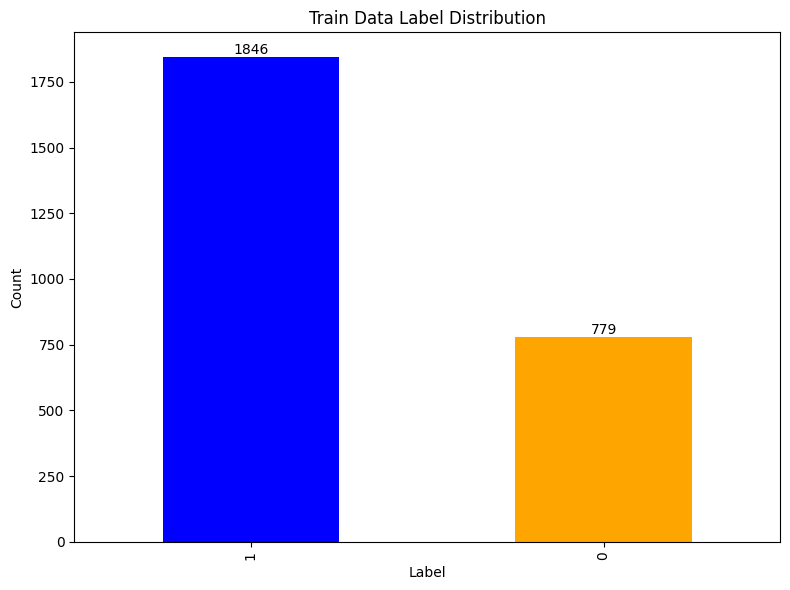

In [ ]:
# Calculate label distribution for the entire train_data
train_label_distribution = train_data['label'].value_counts()

# Print label distribution
print("Label distribution for train data:")
print(train_label_distribution)

# Plot bar chart for train data label distribution
plt.figure(figsize=(8, 6))
train_label_distribution.plot(kind='bar', color = ['blue', 'orange'])  # Using default color
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Train Data Label Distribution')

# Add label counts on top of the bars
for i, v in enumerate(train_label_distribution):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
train_data = train_data.drop(columns=['order_id', 'order_id_cat'])
test_data = test_data.drop(columns=['order_id', 'order_id_cat'])
train_data = train_data.dropna()

In [ ]:
# Feature and target for train and test sets
X_train = train_data.drop(columns=['label'])
y_train = train_data['label']
X_test = test_data.drop(columns=['label'])
y_test = test_data['label']

In [ ]:
X_train = train_data[['speed_mean', 'speed_median', 'speed_min', 'speed_max', "unavailable_count",
        "latitude_mean",
        "latitude_median",
        "latitude_min",
        "latitude_max",
        "longitude_mean",
        "longitude_median",
        "longitude_min",
        "longitude_max","accuracy_in_meters_min"]]
X_test = test_data[['speed_mean', 'speed_median', 'speed_min', 'speed_max',   "unavailable_count",
        "latitude_mean",
        "latitude_median",
        "latitude_min",
        "latitude_max",
        "longitude_mean",
        "longitude_median",
        "longitude_min",
        "longitude_max","accuracy_in_meters_min"]]

## 6.2&nbsp;XGB Classifier without any sampling

In [ ]:
# Pipeline
pipe = make_pipeline(StandardScaler(), XGBClassifier())

# Define multiple scoring metrics
scoring = {
    'acc': 'accuracy',
    'prec_macro': 'precision_macro',
    'rec_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# Stratified K-Fold
stratkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation. Ignore the warning
cv_scores = cross_validate(pipe, X_train, y_train, cv=stratkfold, scoring=scoring)

# Fit pipeline to train set
pipe.fit(X_train, y_train)

# Predict on test set
y_pred = pipe.predict(X_test)
X_test_with_pred = X_test.copy()
X_test_with_pred['original_label'] = y_test
X_test_with_pred['predicted_label'] = y_pred

combined_test_data = X_test_with_pred


# Calculate binary cross-entropy loss
bce_loss_final = log_loss(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])
print("Final Binary Cross-Entropy Loss:", bce_loss_final)


Final Binary Cross-Entropy Loss: 5.849370035719584


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       260
           1       0.89      0.88      0.88       615

    accuracy                           0.84       875
   macro avg       0.81      0.81      0.81       875
weighted avg       0.84      0.84      0.84       875

Precision: 0.8883415435139573
Accuracy: 0.8377142857142857
Recall: 0.8796747967479674


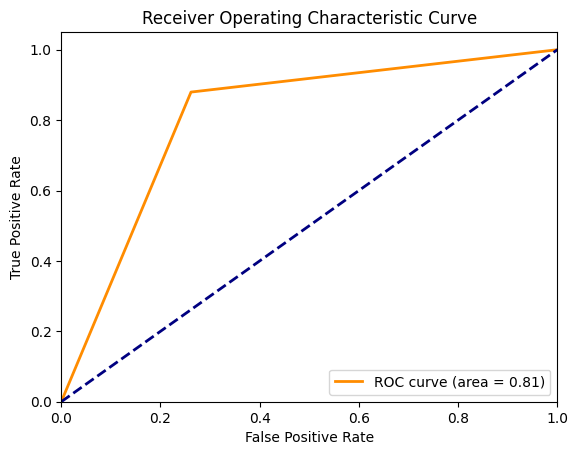

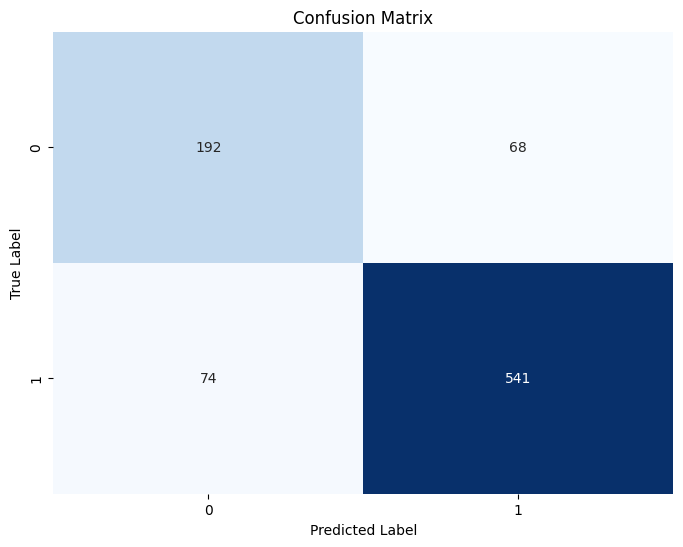

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(X_test_with_pred['original_label'], X_test_with_pred['predicted_label']))

# Precision
precision = precision_score(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])
print("Precision:", precision)

# Accuracy
accuracy = accuracy_score(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])
print("Accuracy:", accuracy)

# Recall
recall = recall_score(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])
print("Recall:", recall)

# AUC ROC curve
auc_roc = roc_auc_score(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


# Compute confusion matrix
conf_matrix = confusion_matrix(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 6.3&nbsp; XGB Classifier after oversampling minority class (SMOTE)

In [ ]:
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)
from collections import Counter
print(Counter(y_train))
print(Counter(y_train_sm))

Counter({1: 1831, 0: 765})
Counter({1: 1831, 0: 1831})


In [ ]:
# Pipeline
pipe = make_pipeline(StandardScaler(), XGBClassifier())

# Define multiple scoring metrics
scoring = {
    'acc': 'accuracy',
    'prec_macro': 'precision_macro',
    'rec_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# Stratified K-Fold
stratkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation. Ignore the warning
cv_scores = cross_validate(pipe, X_train_sm, y_train_sm, cv=stratkfold, scoring=scoring)

# Fit pipeline to train set
pipe.fit(X_train_sm, y_train_sm)

# Predict on test set
y_pred = pipe.predict(X_test)
X_test_with_pred = X_test.copy()
X_test_with_pred['original_label'] = y_test
X_test_with_pred['predicted_label'] = y_pred

# Calculate binary cross-entropy loss
bce_loss_final = log_loss(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])
print("Final Binary Cross-Entropy Loss:", bce_loss_final)


Final Binary Cross-Entropy Loss: 6.17891200956294


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74       260
           1       0.91      0.84      0.87       615

    accuracy                           0.83       875
   macro avg       0.79      0.82      0.80       875
weighted avg       0.84      0.83      0.83       875

Precision: 0.911504424778761
Accuracy: 0.8285714285714286
Recall: 0.8373983739837398


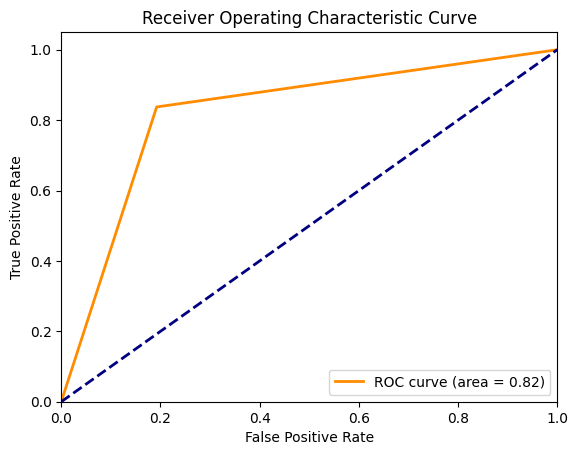

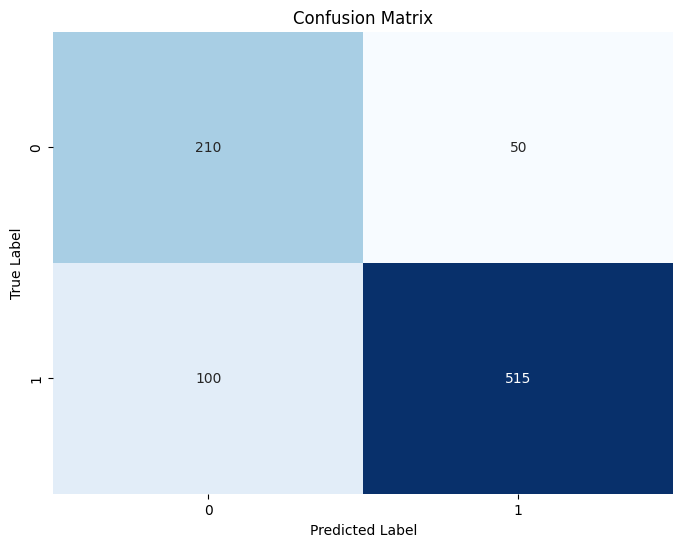

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(X_test_with_pred['original_label'], X_test_with_pred['predicted_label']))

# Precision
precision = precision_score(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])
print("Precision:", precision)

# Accuracy
accuracy = accuracy_score(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])
print("Accuracy:", accuracy)

# Recall
recall = recall_score(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])
print("Recall:", recall)

# AUC ROC curve
auc_roc = roc_auc_score(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


# Compute confusion matrix
conf_matrix = confusion_matrix(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 6.3.1 XGBClassifier with Parameter Tuning

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import log_loss

# Define custom scoring function with multiple metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

# Define the pipeline
pipe = make_pipeline(StandardScaler(), XGBClassifier())

# Define the parameter distributions with widened ranges
param_dist = {
    'xgbclassifier__learning_rate': uniform(0.01, 0.3),  # Widened range for learning rate
    'xgbclassifier__n_estimators': randint(100, 3001),  # Expanded range for number of estimators
    'xgbclassifier__max_depth': randint(3, 15),  # Expanded range for maximum depth of trees
    'xgbclassifier__subsample': uniform(0.5, 0.5),  # Adjusted range for subsample ratio
    'xgbclassifier__colsample_bytree': uniform(0.5, 0.5),  # Adjusted range for colsample_bytree
    'xgbclassifier__gamma': uniform(0, 0.5),  # Adjusted range for gamma
    'xgbclassifier__reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10],  # Adjusted range for reg_alpha
    'xgbclassifier__reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10]  # Adjusted range for reg_lambda
}

# Stratified K-Fold
stratkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=300, cv=stratkfold, scoring=scoring, refit='f1_macro', verbose=2, n_jobs=-1)

# Fit RandomizedSearchCV
random_search.fit(X_train_sm, y_train_sm)

# Get the best estimator
best_estimator_random = random_search.best_estimator_

# Fit the best estimator to the train set (optional, RandomizedSearchCV already fits the best estimator)
best_estimator_random.fit(X_train_sm, y_train_sm)

# Predict on the test set
y_pred_random = best_estimator_random.predict(X_test)

# Calculate binary cross-entropy loss
bce_loss_final_random = log_loss(y_test, y_pred_random)
print("Final Binary Cross-Entropy Loss (RandomizedSearchCV):", bce_loss_final_random)

X_test_with_pred = X_test.copy()
X_test_with_pred['original_label'] = y_test
X_test_with_pred['predicted_label'] = y_pred_random

# Classification Report
print("Classification Report:")
print(classification_report(X_test_with_pred['original_label'], X_test_with_pred['predicted_label']))

# Precision
precision = precision_score(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])
print("Precision:", precision)

# Accuracy
accuracy = accuracy_score(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])
print("Accuracy:", accuracy)

# Recall
recall = recall_score(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])
print("Recall:", recall)

# AUC ROC curve
auc_roc = roc_auc_score(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# Compute confusion matrix
conf_matrix = confusion_matrix(X_test_with_pred['original_label'], X_test_with_pred['predicted_label'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 6.4 Feature Importance Plot

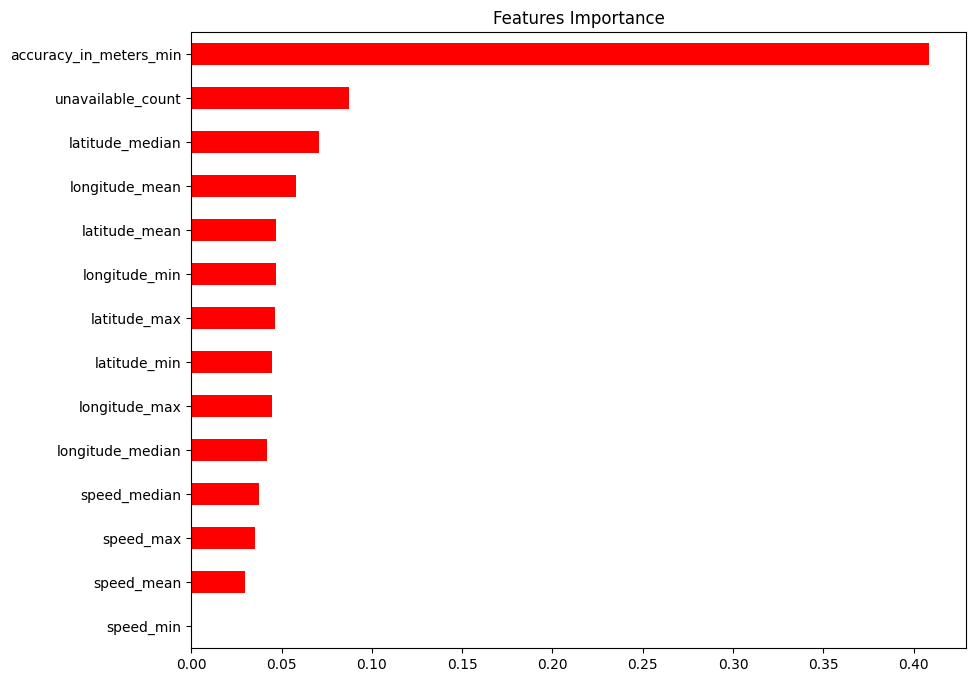

In [ ]:
# Set the size of the figure
plt.figure(figsize=(10, 8))

# Create a pd.Series of features importances
fimp = pipe.steps[1][1].feature_importances_
importances = pd.Series(data=fimp, index=X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='red')
plt.title('Features Importance')
plt.show()


## 6.5 Finding similar rows with contrasting prediction labels

In [ ]:
# Fill NaN values with zeros
combined_test_data_filled = combined_test_data.fillna(0)

# Compute cosine similarity between rows
similarity_matrix = cosine_similarity(combined_test_data_filled.drop(columns=['predicted_label']))

# Find pairs of rows with contrasting predicted labels and high similarity
threshold = 0.9  # Adjust as needed
contrasting_pairs = []

for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        if (combined_test_data.iloc[i]['predicted_label'] != combined_test_data.iloc[j]['predicted_label'] and
            combined_test_data.iloc[i]['original_label'] == combined_test_data.iloc[j]['original_label'] and
            similarity_matrix[i][j] >= threshold):
            contrasting_pairs.append((i, j))

### 6.5.1&nbsp;An example of a pair of rows with contrasting predictions but similar features

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("First pair of rows with contrasting predicted labels and high similarity:")
if contrasting_pairs:
    i, j = contrasting_pairs[0]
    row_i = combined_test_data.iloc[i]
    row_j = combined_test_data.iloc[j]
    print("Pair:")
    print("Row", i, ":", row_i.to_dict())
    print("Row", j, ":", row_j.to_dict())
else:
    print("No contrasting pairs found with high similarity.")


First pair of rows with contrasting predicted labels and high similarity:
Pair:
Row 0 : {'speed_mean': 4.245222172952441, 'speed_median': 0.01779946334368363, 'speed_min': 0.0, 'speed_max': 68.18154311254322, 'unavailable_count': 0.0, 'latitude_mean': -6.863818734177215, 'latitude_median': -6.8640087, 'latitude_min': -6.8643023, 'latitude_max': -6.8613375, 'longitude_mean': 107.57134109493671, 'longitude_median': 107.5718273, 'longitude_min': 107.565867, 'longitude_max': 107.571852, 'accuracy_in_meters_min': 13.715, 'original_label': 1.0, 'predicted_label': 1.0}
Row 16 : {'speed_mean': 4.45992056572925, 'speed_median': 0.27846103448193454, 'speed_min': 0.0, 'speed_max': 82.1127747117864, 'unavailable_count': 1.0, 'latitude_mean': -6.906399666176471, 'latitude_median': -6.904737, 'latitude_min': -6.9098962, 'latitude_max': -6.9041229, 'longitude_mean': 107.62275823014706, 'longitude_median': 107.6208317, 'longitude_min': 107.6194996, 'longitude_max': 107.627508, 'accuracy_in_meters_min'

### 6.5.2&nbsp;SHAP Force Plot showing the reason for a particular prediction

SHAP values for the first pair of rows with contrasting predicted labels and high similarity:
Row 0 : speed_mean                  4.245222
speed_median                0.017799
speed_min                   0.000000
speed_max                  68.181543
unavailable_count           0.000000
latitude_mean              -6.863819
latitude_median            -6.864009
latitude_min               -6.864302
latitude_max               -6.861338
longitude_mean            107.571341
longitude_median          107.571827
longitude_min             107.565867
longitude_max             107.571852
accuracy_in_meters_min     13.715000
original_label              1.000000
predicted_label             1.000000
Name: 5, dtype: float64


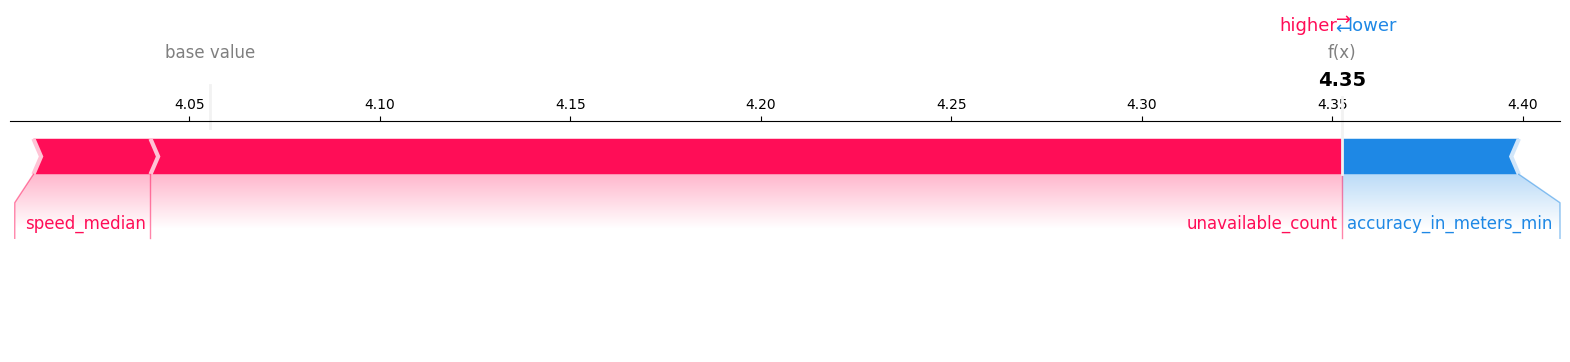

Row 16 : speed_mean                  4.459921
speed_median                0.278461
speed_min                   0.000000
speed_max                  82.112775
unavailable_count           1.000000
latitude_mean              -6.906400
latitude_median            -6.904737
latitude_min               -6.909896
latitude_max               -6.904123
longitude_mean            107.622758
longitude_median          107.620832
longitude_min             107.619500
longitude_max             107.627508
accuracy_in_meters_min      1.990000
original_label              1.000000
predicted_label             0.000000
Name: 60, dtype: float64


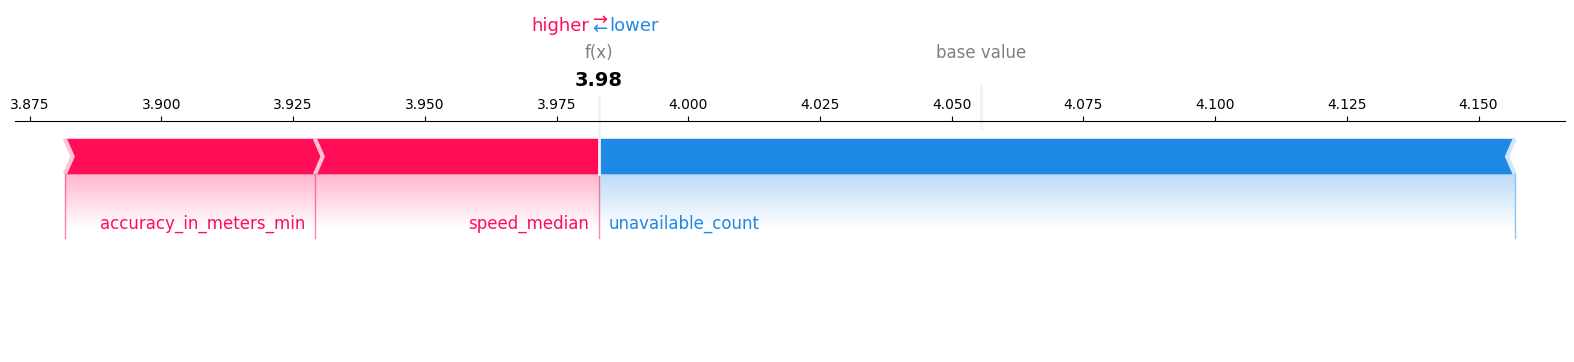

In [ ]:
# Fit SHAP explainer
explainer = shap.Explainer(pipe.named_steps['xgbclassifier'], X_train)

# Compute SHAP values for the first pair
if contrasting_pairs:
    i, j = contrasting_pairs[0]
    instances = combined_test_data.iloc[[i, j]]
    shap_values_instances = explainer.shap_values(instances.drop(columns=['original_label', 'predicted_label']))

    # Visualize SHAP values for the first pair
    print("SHAP values for the first pair of rows with contrasting predicted labels and high similarity:")
    for idx, shap_values_instance in enumerate(shap_values_instances):
        print("Row", contrasting_pairs[0][idx], ":", instances.iloc[idx])
        shap.force_plot(explainer.expected_value, shap_values_instance, feature_names=instances.drop(columns=['original_label', 'predicted_label']).columns, matplotlib=True)
        plt.show()
else:
    print("No contrasting pairs found with high similarity.")

SHAP values for the first pair of rows with contrasting predicted labels and high similarity:
Row 0 : speed_mean                  4.245222
speed_median                0.017799
speed_min                   0.000000
speed_max                  68.181543
unavailable_count           0.000000
latitude_mean              -6.863819
latitude_median            -6.864009
latitude_min               -6.864302
latitude_max               -6.861338
longitude_mean            107.571341
longitude_median          107.571827
longitude_min             107.565867
longitude_max             107.571852
accuracy_in_meters_min     13.715000
original_label              1.000000
predicted_label             1.000000
Name: 5, dtype: float64


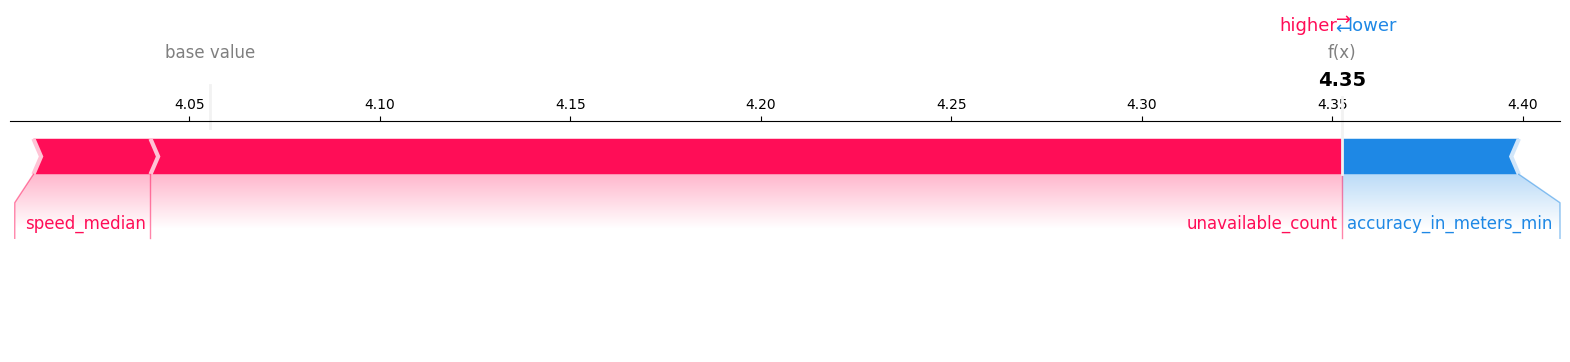

Row 85 : speed_mean                  6.629715
speed_median                0.260994
speed_min                   0.000000
speed_max                  58.992852
unavailable_count           1.000000
latitude_mean              -6.845299
latitude_median            -6.844990
latitude_min               -6.852342
latitude_max               -6.839980
longitude_mean            107.583740
longitude_median          107.584827
longitude_min             107.580693
longitude_max             107.585840
accuracy_in_meters_min      3.000000
original_label              1.000000
predicted_label             0.000000
Name: 318, dtype: float64


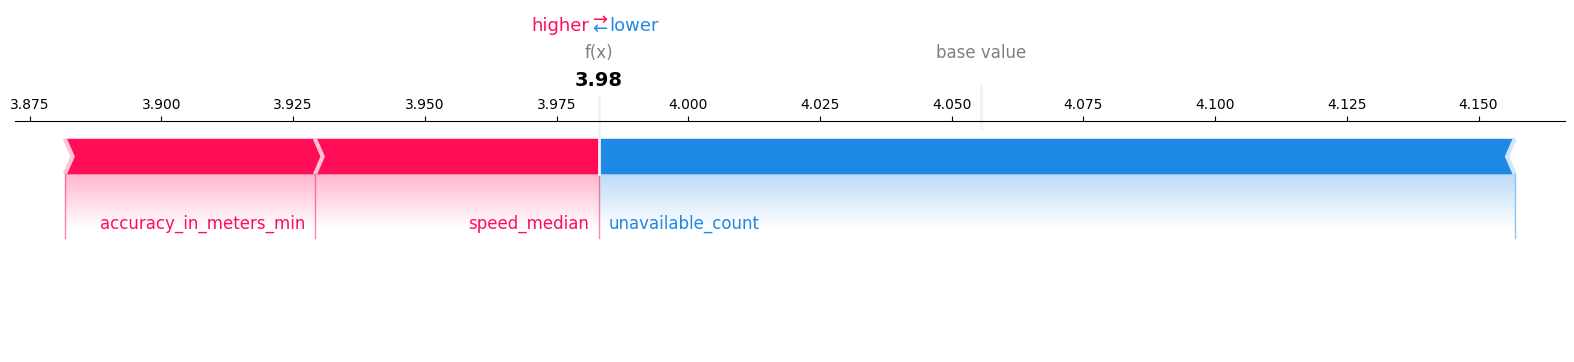

In [ ]:
# Fit SHAP explainer
explainer = shap.Explainer(pipe.named_steps['xgbclassifier'], X_train)

# Compute SHAP values for the first pair
index = 3
if contrasting_pairs:
    i, j = contrasting_pairs[index]
    instances = combined_test_data.iloc[[i, j]]
    shap_values_instances = explainer.shap_values(instances.drop(columns=['original_label', 'predicted_label']))

    # Visualize SHAP values for the first pair
    print("SHAP values for the first pair of rows with contrasting predicted labels and high similarity:")
    for idx, shap_values_instance in enumerate(shap_values_instances):
        print("Row", contrasting_pairs[index][idx], ":", instances.iloc[idx])
        shap.force_plot(explainer.expected_value, shap_values_instance, feature_names=instances.drop(columns=['original_label', 'predicted_label']).columns, matplotlib=True)
        plt.show()
else:
    print("No contrasting pairs found with high similarity.")

### 6.5.3&nbsp;SHAP summary plot showing feature importance

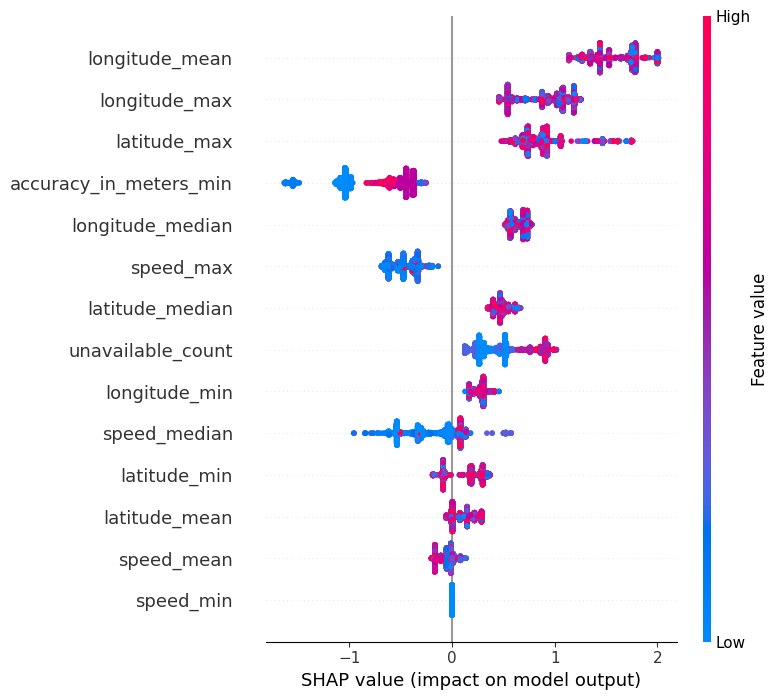

In [ ]:
shap_values = shap.TreeExplainer(pipe.named_steps['xgbclassifier']).shap_values(X_train_sm)
# Create a summary plot
shap.summary_plot(shap_values, X_train_sm, feature_names=X_train_sm.columns)